In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

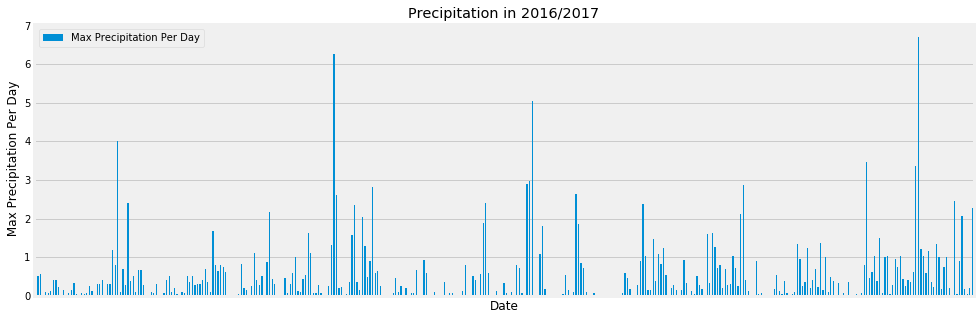

<Figure size 432x288 with 0 Axes>

In [11]:
# Display the Measurement's columns and data in dictionary format
# first_row = session.query(Measurement).first()
# first_row.__dict__

# Display the Station's columns and data in dictionary format
# first_row = session.query(Station).first()
# first_row.__dict__

# Use the session to query Measurement table and display the first 12 locations
# for row in session.query(Measurement, Measurement.prcp).limit(12).all():
#     print(row)
    
# Query Measurement table precipitation and date, and order by date
results = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date).all()  

# Save the query results as a Pandas DataFrame
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# # Multiple precipitation reading per day, take the Maximum Recorded precipitation per day
dfg = df.groupby(["Date"]).max()
dfg.rename(columns={'Precipitation' : 'Max Precipitation Per Day'}, inplace=True)

# Sort the dataframe by date
dfg = dfg.sort_values('Date', ascending=False)
dfg = dfg.reset_index()

# Convert the Date column from string to date object format  
dfg['Date'] = pd.to_datetime(dfg['Date'])

# Get the last 12 months of data   
first_month = dfg.iloc[0,0]
last_month = first_month - dt.timedelta(days=365)
df_12m = dfg.loc[dfg['Date'] > last_month]

df_12m.set_index('Date', inplace=True)

df_12m.plot(kind='bar', rot=0, figsize=(15,5))
plt.xticks([])

plt.title("Precipitation in 2016/2017")
plt.xlabel("Date")
plt.ylabel(" Max Precipitation Per Day")

plt.savefig("Images/precipitation.png")
plt.show()
plt.tight_layout()



In [12]:
# Use Pandas to calcualte the last 12 months summary statistics for the precipitation data 
df_12m.describe()

,Max Precipitation Per Day
count,365.000000
mean,0.517288
std,0.829196
min,0.000000
25%,0.040000
50%,0.250000
75%,0.650000
max,6.700000


In [13]:
# Query Measurement table for Station 
results = session.query(Measurement.station, Measurement.date, Measurement.tobs).order_by(Measurement.station).all()  

# Save the query results as a Pandas DataFrame
dfs = pd.DataFrame(results, columns=['Station', 'Date', 'Temperature'])

# Get the Station count
dfs1 = dfs["Station"].value_counts()
print(f"Total Number of Stations are {dfs1.count()}")


Total Number of Stations are 9


In [15]:
dfs1 = dfs1.reset_index()

# Rename the header
dfs1.rename(columns={'index' : 'Station id', 'Station' : 'Activity Level'}, inplace=True)

# Sort the stations by most active
dfs1 = dfs1.sort_values('Activity Level', ascending=False)

most_active_station = dfs1.iloc[0,0]

dfs1 = dfs1.set_index("Station id")

dfs1

,Activity Level
Station id,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [16]:
# Get the lowest temperature recorded, highest temperature recorded, and average temperature of most active station
dfs_ma = dfs.loc[dfs['Station'] == most_active_station]

print(f"Most Active Station is {most_active_station}")
print(f"Lowest Recorded Temperature of Most Active Station is {dfs_ma['Temperature'].min()}")
print(f"Highest Recorded Temperature of Most Active Station is {dfs_ma['Temperature'].max()}")
print(f"Average Recorded Temperature of Most Active Station is {dfs_ma['Temperature'].mean()}")
      


Most Active Station is USC00519281
Lowest Recorded Temperature of Most Active Station is 54.0
Highest Recorded Temperature of Most Active Station is 85.0
Average Recorded Temperature of Most Active Station is 71.66378066378067


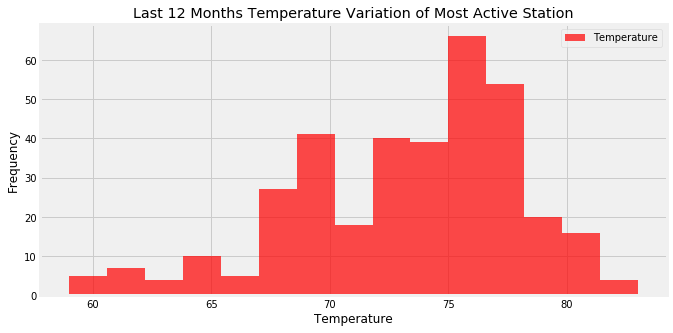

<Figure size 432x288 with 0 Axes>

In [18]:
dfs_ma1 = dfs_ma[["Date", "Temperature"]]

# Sort the stations by most active
dfs_ma1 = dfs_ma1.sort_values('Date', ascending=False)

# Convert the Date column from string to date object format  
dfs_ma1['Date'] = pd.to_datetime(dfs_ma1['Date'])

# Get the last 12 months of data   
first_month = dfs_ma1.iloc[0,0]
last_month = first_month - dt.timedelta(days=365)
df_ma_12m = dfs_ma1.loc[dfs_ma1['Date'] > last_month]

df_ma_12m.set_index('Date', inplace=True)

df_ma_12m.plot.hist(bins=15, alpha=0.7, color = 'red', figsize=(10,5))

plt.title("Last 12 Months Temperature Variation of Most Active Station")
plt.xlabel("Temperature")

plt.savefig("Images/station-histogram.png.png")
plt.show()
plt.tight_layout()


In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# My trip is for  10 days from Feb 28, 2017 to March 10, 2017 
trip_start_date = '2017-02-28'
trip_end_date = '2017-03-10'

calc_temps(trip_start_date, trip_end_date)

[(62.0, 70.53623188405797, 78.0)]

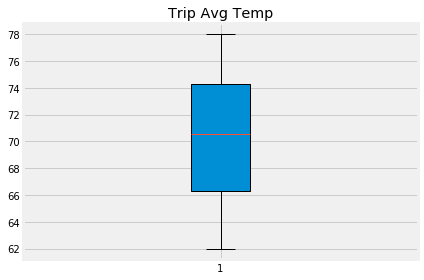

In [23]:
fig, ax = plt.subplots()

ax.boxplot(calc_temps('2017-02-28', '2017-03-10'), patch_artist=True)
ax.set_title('Trip Avg Temp')

plt.savefig("Images/tripAvgTemp.png")
fig.tight_layout()
plt.show()

In [24]:
# Query Measurement table   
measure_results = session.query(Measurement.station, Measurement.date, Measurement.prcp).order_by(Measurement.station).all()  

# Save the query results as a Pandas DataFrame
measure_df = pd.DataFrame(measure_results, columns=['Station Id', 'Date', 'Precipitation'])

# Sort the dataframe by date
measure_df = measure_df.sort_values('Date', ascending=False)

# Convert the Date column from string to date object format  
measure_df['Date'] = pd.to_datetime(measure_df['Date'])

# Get the last 12 months of data   
start_date = pd.to_datetime(trip_start_date)
end_date = pd.to_datetime(trip_end_date)

measure_df = measure_df.loc[(measure_df['Date'] >= start_date) & (measure_df['Date'] <= end_date)]

# Query Station table   
station_results = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).order_by(Station.station).all()  

# Save the query results as a Pandas DataFrame
station_df = pd.DataFrame(station_results, columns=['Station Id', 'Station Name', 'Latitude', 'Longitude', 'Elevation'])

#Merge the dataframes
merge_df = pd.merge(measure_df, station_df, how="inner", on="Station Id").fillna(0)

neworder = ['Date','Precipitation','Station Id','Station Name','Latitude', 'Longitude', 'Elevation']
merge_df = merge_df.reindex(columns=neworder)

# Sort the stations by most active
merge_df = merge_df.sort_values('Precipitation', ascending=False)

merge_df = merge_df.set_index("Date")

merge_df.head()

,Precipitation,Station Id,Station Name,Latitude,Longitude,Elevation
Date,,,,,,
2017-03-01,2.40,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
2017-03-01,2.20,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2017-03-01,2.12,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2017-03-01,2.00,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
2017-03-02,1.88,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9


## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# Reference the start_date and end_date from earlier 

temp_date = start_date
date_list = []
daily_normal_list = []

while temp_date <= end_date:
    append_date = temp_date.strftime("%m-%d")
    date_list.append(append_date)
    daily_normal_list.append(daily_normals(append_date))
    temp_date = temp_date + dt.timedelta(days=1) 

# Print the daily normal of my trip dates
#date_list
daily_normal_list

[[(65.0, 70.65517241379311, 80.0)],
 [(64.0, 70.0327868852459, 76.0)],
 [(61.0, 70.36666666666666, 78.0)],
 [(60.0, 70.06896551724138, 78.0)],
 [(57.0, 69.27272727272727, 77.0)],
 [(60.0, 67.89090909090909, 76.0)],
 [(60.0, 69.20338983050847, 76.0)],
 [(60.0, 69.17241379310344, 78.0)],
 [(59.0, 68.72413793103448, 78.0)],
 [(57.0, 68.56140350877193, 75.0)],
 [(57.0, 69.12280701754386, 75.0)]]

In [28]:
combined_list = []

total_item = len(date_list)

for item in range(len(date_list)):
    merge_list = {}
    merge_list['date'] = date_list[item]
    merge_list['tmin'] = daily_normal_list[item][0][0]
    merge_list['tavg'] = daily_normal_list[item][0][1]
    merge_list['tmax'] = daily_normal_list[item][0][2]
    combined_list.append(merge_list)
    
combined_list

df = pd.DataFrame(combined_list) 
df = df.reindex(columns=['date', 'tmin', 'tavg', 'tmax'])
df = df.set_index("date")
df

,tmin,tavg,tmax
date,,,
02-28,65.0,70.655172,80.0
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0
03-05,60.0,67.890909,76.0
03-06,60.0,69.203390,76.0
03-07,60.0,69.172414,78.0
03-08,59.0,68.724138,78.0


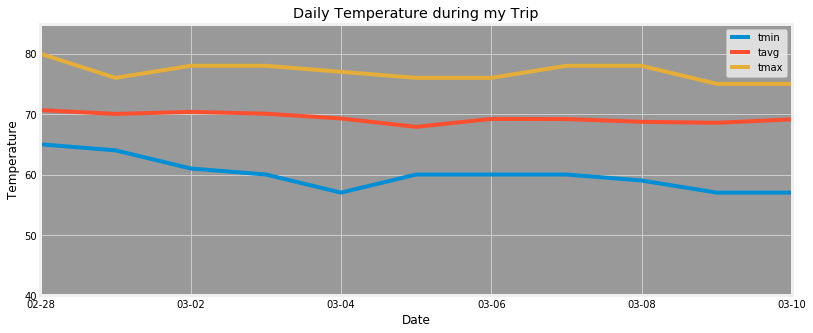

<Figure size 432x288 with 0 Axes>

In [63]:
ax = df.plot(kind='line', stacked=False, figsize=(12,5))
ax.set_ylim((40, 85))
ax.set_facecolor((0.6, 0.6, 0.6))

ax.set_yticks(np.arange(40, 90, step=10))

ax.set_title("Daily Temperature during my Trip")
ax.set_xlabel("Date")
ax.set_ylabel("Temperature")
           
           
plt.savefig("Images/daily_normals.png")
plt.show()
plt.tight_layout()